# Brain Tumor

## Problem Statement

Brain tumors arise due to the uncontrolled and rapid proliferation of cells, making them the 12th leading cause of cancer-related deaths globally, as per the Global Burden of Disease (GBD) rankings. This high mortality rate, along with the significant financial burden on individuals and society, low survival rates, and profound impact on patients' quality of life, underscores the critical need for early and accurate detection of brain tumors for effective treatment planning and improved patient outcomes.

Traditional methods for diagnosing brain tumors rely on radiologists manually analyzing magnetic resonance imaging (MRI) scans. This process is not only labor-intensive but also subjective and susceptible to human error. The variability in tumor location, appearance, shape, and size further complicates accurate detection. Convolutional neural networks (CNNs) offer a promising solution to enhance and automate the detection and classification of brain tumors, addressing these challenges.

#### Objectives

This project aims to utilize Convolutional Neural Networks (CNNs) to:
1. Detect the presence of brain tumors in MRI images.
2. Classify brain tumors based on their type: glioma, meningioma, no tumor, and pituitary.

## Data Description

This dataset is a combination of three distinct datasets: figshare, the SARTAJ dataset, and Br35H. It comprises a total of 7,023 MRI images of the human brain, which are meticulously classified into four categories: glioma, meningioma, no tumor, and pituitary. The images classified under the "no tumor" category were specifically sourced from the Br35H dataset. This comprehensive collection serves as a valuable resource for medical imaging research, providing a diverse range of examples for each class to facilitate accurate classification and analysis.



## Table of Contents


1. [Problem Statement](#1.-Problem-Statement)

2. [Data Description](#2.-Data-Description)

3. [Table of Contents](#3.-Table-of-Contents)

4. [Importation of Libraries and Packages](#4.-Importation-of-Libraries-and-Packages)

5. [Data Importation](5.-Data-Importation)

6. [Data Overview](#6.-Data-Overview)

7. [Exploratory Data Analysis](#7.-Exploratory-Data-Analysis)

8. [Data Preprocessing](#8.-Data-Preprocessing)

10. [Model Building](#10.-Model-Building)

11. [Model Validation](#11.-Model-Validation)

12. [Model Comparison and Selection](#10.-Model-Comparison-and-Selection)

13. [Summary](#12.-Summary)

### Importation of Libraries and Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import random
from sklearn.model_selection import train_test_split
import os
import cv2
import math
import keras.utils as ku
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout,GlobalAveragePooling2D,SpatialDropout2D
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import f1_score


2024-06-29 09:50:06.144558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 09:50:06.144733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 09:50:06.280116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Importation

In [3]:
# Set the path to your dataset
data_path = '../input/brain-tumor-mri-dataset/'

# Load the image file paths
image_paths = glob(os.path.join(data_path, '**/*.jpg'), recursive=True)

# Load the labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]



### Data Overview

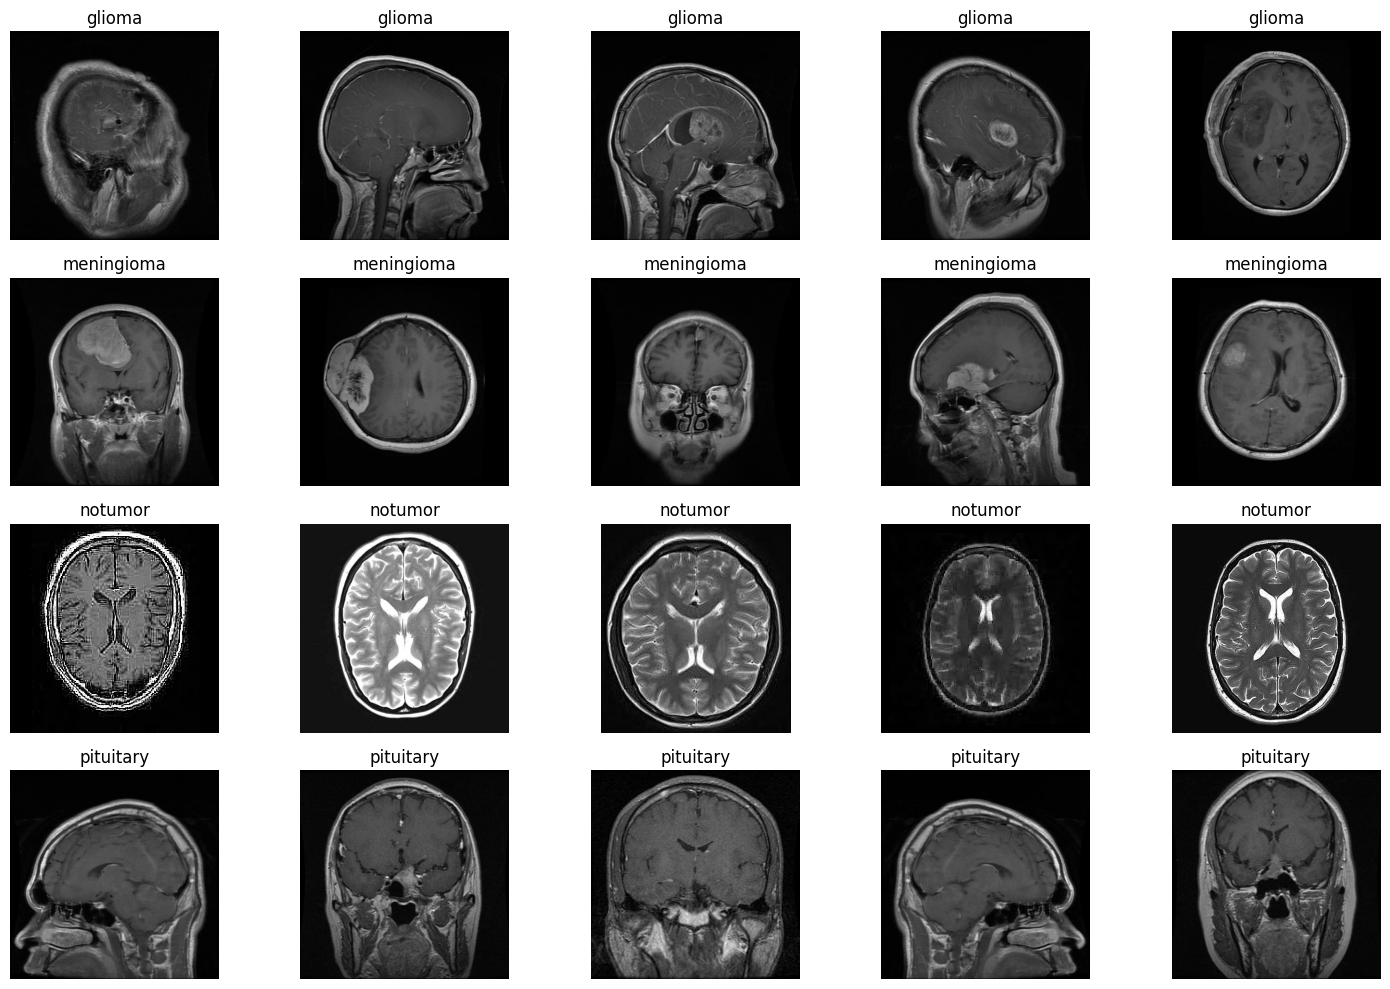

In [4]:
def show_sample_images(image_paths, labels, class_names, samples_per_class=5):
    plt.figure(figsize=(15, 10))
    for class_index, class_name in enumerate(class_names):
        class_images = [img for img, lbl in zip(image_paths, labels) if lbl == class_name]
        for i in range(samples_per_class):
            plt.subplot(len(class_names), samples_per_class, class_index * samples_per_class + i + 1)
            img = cv2.imread(class_images[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.savefig('overview.jpg')
    plt.show()

class_names = sorted(set(labels))
show_sample_images(image_paths, labels, class_names)


In [4]:
# Summary Statistics
dimensions = [cv2.imread(img).shape for img in image_paths]
dims_df = pd.DataFrame(dimensions, columns=['Height', 'Width', 'Channels'])

print(dims_df.describe())

            Height        Width  Channels
count  7023.000000  7023.000000    7023.0
mean    448.346860   445.891499       3.0
std     126.282922   132.328035       0.0
min     168.000000   150.000000       3.0
25%     403.500000   393.000000       3.0
50%     512.000000   512.000000       3.0
75%     512.000000   512.000000       3.0
max    1446.000000  1920.000000       3.0


### Exploratory Data Analysis

#### Edge Detection

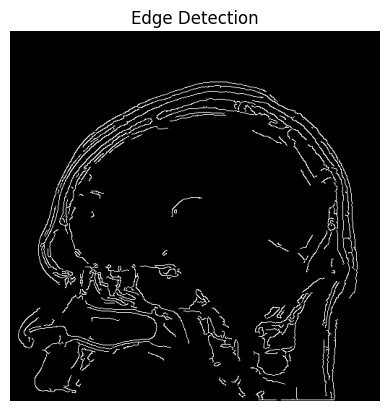

In [8]:
def edge_detection(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')
    plt.show()

edge_detection(image_paths[0])


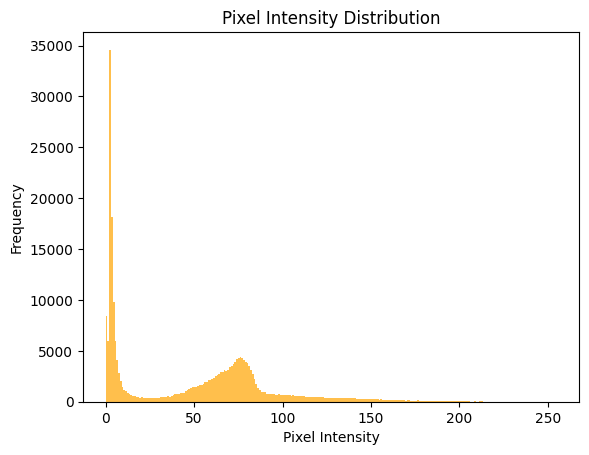

In [5]:
def plot_pixel_intensity(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.hist(img.ravel(), bins=256, color='orange', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution')
    plt.show()

plot_pixel_intensity(image_paths[0])


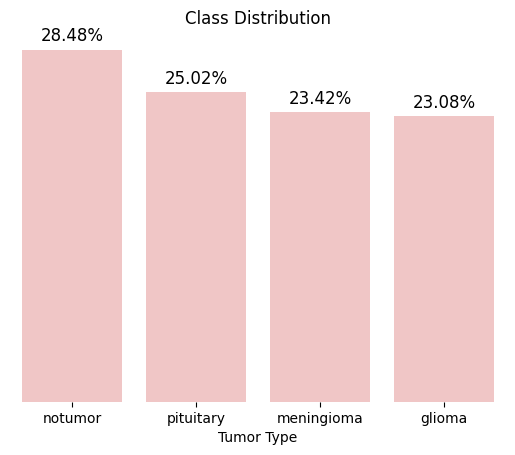

In [6]:
labels_df = pd.DataFrame(labels, columns=['Label'])
order=['notumor', 'pituitary','meningioma', 'glioma']
sns.countplot(x='Label', data=labels_df,color='lightcoral' ,order=order, alpha=0.5)
sns.despine(left=True, bottom=True, right=True, top=True)
total = len(labels_df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 50, f'{height / total:.2%}',
             ha="center", fontdict={'fontsize':12})

plt.xlabel('Tumor Type')
plt.ylabel('')
plt.yticks([])
plt.title('Class Distribution')
plt.savefig('class_image.jpg')
plt.show()

### Data Preprocessing

#### Data Augmentation

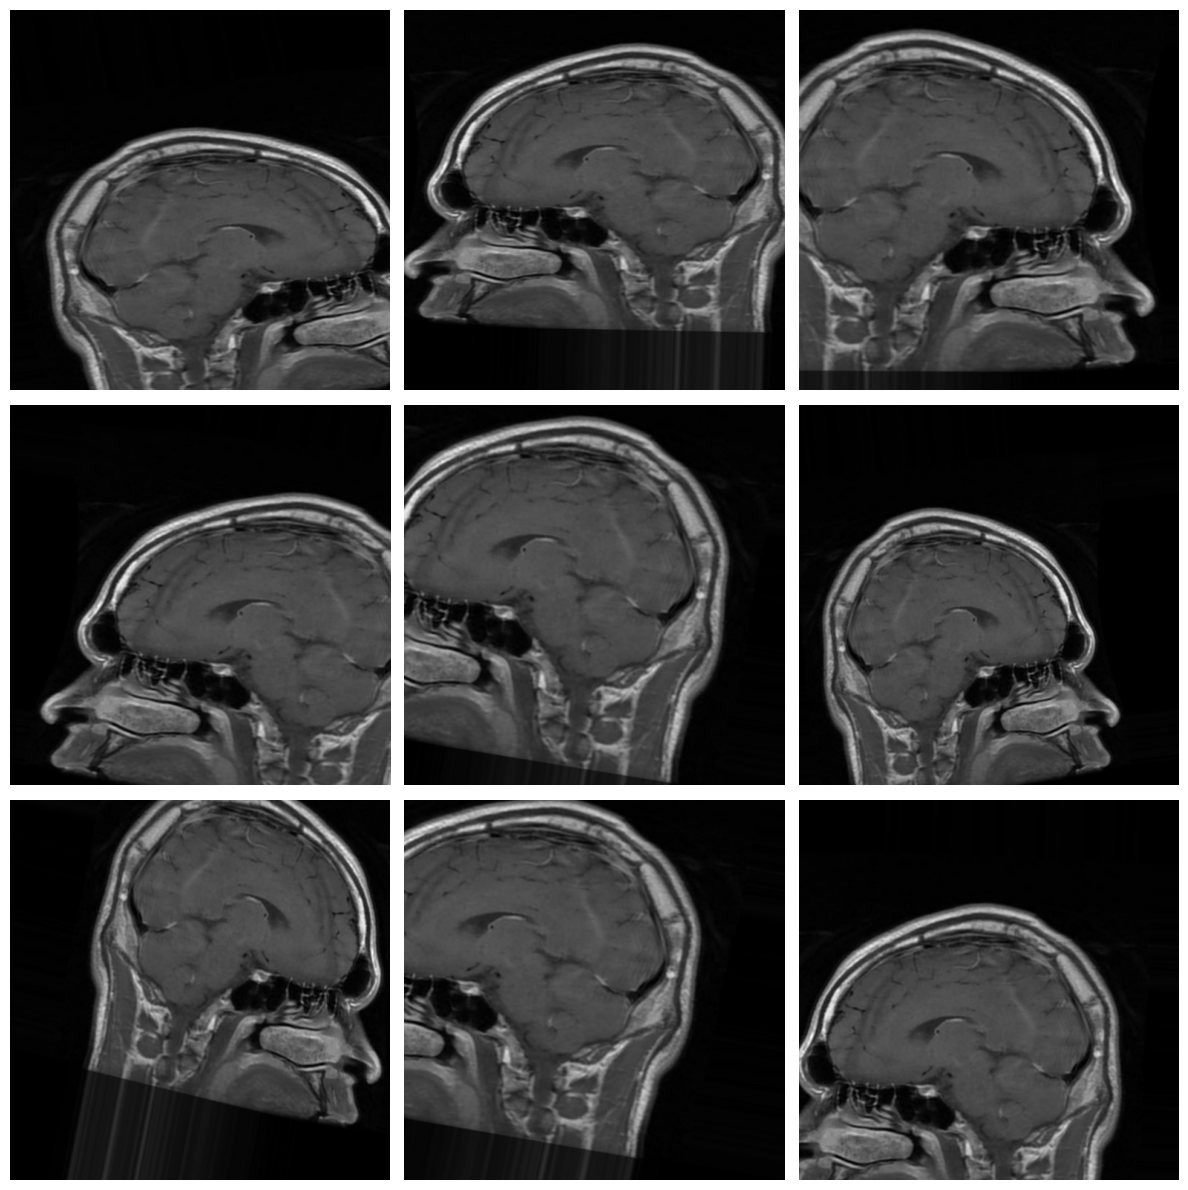

In [7]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
     

def visualize_augmented_images(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(img)

    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        aug_img = next(aug_iter)[0].astype('uint8')
        plt.imshow(aug_img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('aug_image.jpg')
    plt.show()
    

visualize_augmented_images(image_paths[0])


### Model Building

#### VGG19

##### VGG19 Data Preprocessing and Image Augmentation

In [19]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load training and validation data, resizing images to 224x224
train_generator = datagen.flow_from_directory(
    '../input/brain-tumor-mri-dataset/Training',
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '../input/brain-tumor-mri-dataset/Testing',
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


##### VGG19 Model Building

In [16]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during the training process
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##### VGG19 Model Training

In [20]:
# Train the model
vgg19_history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                    validation_data=valid_generator, 
                    validation_steps=valid_generator.samples // valid_generator.batch_size, 
                    epochs=18)

Epoch 1/18


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717672019.862254     206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717672019.883027     206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/178 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.5719 - loss: 6.1011

W0000 00:00:1717672057.236560     207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6022 - loss: 5.3141

W0000 00:00:1717672065.701004     207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 86s 290ms/step - accuracy: 0.6027 - loss: 5.3008 - val_accuracy: 0.8523 - val_loss: 0.5497
Epoch 2/18
  1/178 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.7812 - loss: 1.3728

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.7812 - loss: 1.3728 - val_accuracy: 0.9032 - val_loss: 0.5050
Epoch 3/18


W0000 00:00:1717672100.550786     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.8067 - loss: 0.9649 - val_accuracy: 0.8930 - val_loss: 0.3173
Epoch 4/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.8750 - loss: 0.4420 - val_accuracy: 0.8387 - val_loss: 0.4413
Epoch 5/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - accuracy: 0.8414 - loss: 0.5742 - val_accuracy: 0.8945 - val_loss: 0.3152
Epoch 6/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.9062 - loss: 0.5463 - val_accuracy: 0.9677 - val_loss: 0.2234
Epoch 7/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.8764 - loss: 0.4297 - val_accuracy: 0.9094 - val_loss: 0.2674
Epoch 8/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.9375 - loss: 0.2464 - val_accuracy: 0.9677 - val_loss: 0.0695
Epoch 9/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.9028 - loss: 0.3129 - val_accuracy: 0.9195 - val_loss: 0.2744
Epoch 10/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.9375 - loss: 0.3439 - val_ac

##### VGG19 Model Evaluation

In [24]:
# Evaluate the model on the validation set
vgg19_val_loss, vgg19_val_acc = model.evaluate(valid_generator)
print(f"Validation Loss: {vgg19_val_loss}")
print(f"Validation Accuracy: {vgg19_val_acc}")

# Evaluate the model on the validation set
vgg19_train_loss, vgg19_train_acc = model.evaluate(train_generator)
print(f"Validation Loss: {vgg19_train_loss}")
print(f"Validation Accuracy: {vgg19_train_acc}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9419 - loss: 0.1753
Validation Loss: 0.1818903684616089
Validation Accuracy: 0.9466056227684021
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.9906 - loss: 0.0299
Validation Loss: 0.03278801962733269
Validation Accuracy: 0.9903711676597595


W0000 00:00:1717673891.791493     206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#### DenseNet121

##### DenseNet121 Data Preprocessing and Image Augmentation

In [26]:
densenet_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

densenet_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

densenet_valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

# Load training and validation data, resizing images to 224x224
densenet_train_generator = densenet_datagen.flow_from_directory(
    '../input/brain-tumor-mri-dataset/Training',
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'
)

densenet_valid_generator = densenet_valid_datagen.flow_from_directory(
    '../input/brain-tumor-mri-dataset/Testing',
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


##### DenseNet121 Model Building

In [27]:
# Load pre-trained DenseNet121 model without top (fully connected) layers
base_model2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers to prevent training
for layer in base_model2.layers:
    layer.trainable = False

# Add custom top layers for classification
v = GlobalAveragePooling2D()(base_model2.output)
v = Dense(256, activation='relu')(v)
v = Dropout(0.5)(v)
predictions = Dense(4, activation='softmax')(v)  

# Create  model
model2 = Model(inputs=base_model2.input, outputs=predictions)

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

##### DenseNet121 Model Training

In [28]:
densenet_history = model2.fit(densenet_train_generator, 
                    steps_per_epoch=densenet_train_generator.samples // densenet_train_generator.batch_size, 
                    validation_data=densenet_valid_generator, 
                    validation_steps=densenet_valid_generator.samples // densenet_valid_generator.batch_size, 
                    epochs=15)

Epoch 1/15
  2/178 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.2734 - loss: 2.1559  

W0000 00:00:1717674077.601711     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6837 - loss: 0.8488

W0000 00:00:1717674121.893767     207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.6842 - loss: 0.8474 - val_accuracy: 0.8164 - val_loss: 0.4502
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.8125 - loss: 0.4280 - val_accuracy: 0.8387 - val_loss: 0.4502
Epoch 3/15


W0000 00:00:1717674144.558077     207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.8689 - loss: 0.3677 - val_accuracy: 0.8531 - val_loss: 0.3651
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.8438 - loss: 0.3807 - val_accuracy: 0.8710 - val_loss: 0.3336
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.8840 - loss: 0.3148 - val_accuracy: 0.8687 - val_loss: 0.3197
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.8438 - loss: 0.4031 - val_accuracy: 0.9032 - val_loss: 0.2943
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8908 - loss: 0.2727 - val_accuracy: 0.8977 - val_loss: 0.2622
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.9375 - loss: 0.2868 - val_accuracy: 0.8387 - val_loss: 0.5436
Epoch 9/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9129 - loss: 0.2366 - val_accuracy: 0.8859 - val_loss: 0.2854
Epoch 10/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.9062 - loss: 0.2481 - val_ac

##### DenseNet121 Model Evaluation

In [30]:
# Evaluate the model on the validation set
densenet_val_loss, densenet_val_acc = model2.evaluate(densenet_valid_generator, verbose=1)
print(f"Validation Loss: {densenet_val_loss}")
print(f"Validation Accuracy: {densenet_val_acc}")

densenet_train_loss, densenet_train_acc = model2.evaluate(densenet_train_generator, verbose=1)
print(f"Validation Loss: {densenet_train_loss}")
print(f"Validation Accuracy: {densenet_train_acc}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9230 - loss: 0.2141
Validation Loss: 0.22121773660182953
Validation Accuracy: 0.9206712245941162
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9502 - loss: 0.1324
Validation Loss: 0.133476123213768
Validation Accuracy: 0.9492297172546387


In [ ]:
# for test_images, test_labels in test_dataset.take(1):
#   test_images = test_images.numpy()
#   test_labels = test_labels.numpy()
#   predictions = model.predict(test_images)

#### VGG16

##### VGG16 Data Preprocessing and Image Augmentation

In [35]:
vgg16_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

vgg16_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

vgg16_valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Load training and validation data, resizing images to 224x224
vgg16_train_generator = vgg16_datagen.flow_from_directory(
    '../input/brain-tumor-mri-dataset/Training',
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'
)

vgg16_valid_generator = vgg16_valid_datagen.flow_from_directory(
    '../input/brain-tumor-mri-dataset/Testing',
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


##### VGG16 Model Building

In [36]:
base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during the training process
base_model3.trainable = False

# Add custom layers on top of the base model
y = base_model3.output
y = Flatten()(y)
y = Dense(512, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
predictions = Dense(4, activation='softmax')(y)

# Combine the base model and the custom layers
model3 = Model(inputs=base_model3.input, outputs=predictions)

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model3.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##### VGG16 Model Training

In [38]:
vgg16_history = model3.fit(vgg16_train_generator, 
                    steps_per_epoch=vgg16_train_generator.samples // vgg16_train_generator.batch_size, 
                    validation_data=vgg16_valid_generator, 
                    validation_steps=vgg16_valid_generator.samples // vgg16_valid_generator.batch_size, 
                    epochs=18)

Epoch 1/18
  1/178 ━━━━━━━━━━━━━━━━━━━━ 15:54 5s/step - accuracy: 0.2812 - loss: 24.2015

W0000 00:00:1717674553.689912     208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


172/178 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5788 - loss: 6.2795

W0000 00:00:1717674578.994228     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5823 - loss: 6.1817

W0000 00:00:1717674581.051342     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.5828 - loss: 6.1658 - val_accuracy: 0.8398 - val_loss: 0.6858
Epoch 2/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7188 - loss: 2.2107 - val_accuracy: 0.9355 - val_loss: 0.3296
Epoch 3/18


W0000 00:00:1717674586.910881     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.7932 - loss: 1.1408 - val_accuracy: 0.8852 - val_loss: 0.3750
Epoch 4/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7500 - loss: 1.0815 - val_accuracy: 0.9032 - val_loss: 0.1466
Epoch 5/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.8324 - loss: 0.6388 - val_accuracy: 0.8930 - val_loss: 0.3032
Epoch 6/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.7812 - loss: 0.5358 - val_accuracy: 0.9032 - val_loss: 0.1741
Epoch 7/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - accuracy: 0.8607 - loss: 0.5098 - val_accuracy: 0.8938 - val_loss: 0.3649
Epoch 8/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8125 - loss: 0.4815 - val_accuracy: 1.0000 - val_loss: 0.0522
Epoch 9/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.8931 - loss: 0.3526 - val_accuracy: 0.9359 - val_loss: 0.2089
Epoch 10/18
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.9375 - loss: 0.2777 - val_ac

##### VGG16 Model Evaluation

In [39]:
# Evaluate the model on the validation set
vgg16_val_loss, vgg16_val_acc = model3.evaluate(vgg16_valid_generator, verbose=1)
print(f"Validation Loss: {vgg16_val_loss}")
print(f"Validation Accuracy: {vgg16_val_acc}")

vgg16_train_loss, vgg16_train_acc = model3.evaluate(vgg16_train_generator, verbose=1)
print(f"Validation Loss: {vgg16_train_loss}")
print(f"Validation Accuracy: {vgg16_train_acc}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9289 - loss: 0.2177
Validation Loss: 0.20057323575019836
Validation Accuracy: 0.9405034184455872
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.9891 - loss: 0.0282
Validation Loss: 0.03680671378970146
Validation Accuracy: 0.9879201650619507


W0000 00:00:1717674863.031951     208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#### Custom CNN

##### Custom CNN Data Preprocessing 

In [2]:
# Set a random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# path to your data directory
data_path = '../input/brain-tumor-mri-dataset/'

# Load the training data
train_data_path = os.path.join(data_path, 'Training')
train_image_paths = glob(os.path.join(train_data_path, '/*.jpg'), recursive=True)
train_labels = [os.path.basename(os.path.dirname(path)) for path in train_image_paths]

# Load the testing data
test_data_path = os.path.join(data_path, 'Testing')
test_image_paths = glob(os.path.join(test_data_path, '/*.jpg'), recursive=True)
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_image_paths]

# Convert labels to one-hot encoding
label_to_index = {label: idx for idx, label in enumerate(np.unique(train_labels + test_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
train_labels = [label_to_index[label] for label in train_labels]
test_labels = [label_to_index[label] for label in test_labels]

# Function to preprocess images
def preprocess_image(img_path, img_size=(224, 224)):
    img = load_img(img_path, target_size=img_size, color_mode='rgb')
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1
    return img_array

# Preprocess the training and testing data
x_train = np.array([preprocess_image(img) for img in train_image_paths])
x_test = np.array([preprocess_image(img) for img in test_image_paths])

# Convert labels to categorical
num_classes = len(np.unique(train_labels + test_labels))
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

##### Custom CNN Model Building

In [ ]:
# Define a general cnn model architecture
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##### Custom CNN Model Training

In [ ]:
# Train the model
cnn_history = cnn_model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

##### Custom CNN Evaluation

In [ ]:
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(x_test, y_test verbose=1)
print(f"Validation Loss: {cnn_val_loss}")
print(f"Validation Accuracy: {cnn_val_acc}")

cnn_train_loss, cnn_train_acc = cnn_model.evaluate(x_train,y_train, verbose=1)
print(f"Validation Loss: {cnn_train_loss}")
print(f"Validation Accuracy: {cnnn_train_acc}")

### Model Validation

In [49]:
class_labels=['glioma', 'meningioma','notumor','pituitary']

In [50]:
from tensorflow.keras.preprocessing import image

main_image_dir = '../input/brain-tumor-mri-dataset/Testing'

# Function to get all image paths from the main directory and subdirectories
def get_all_image_paths_and_labels(main_dir):
    img_paths = []
    true_labels = []
    for class_label in class_labels:
        class_dir = os.path.join(main_dir, class_label)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg')):
                img_paths.append(os.path.join(class_dir, file))
                true_labels.append(class_label)
    return img_paths, true_labels

# Get list of all image paths
img_paths,true_labels = get_all_image_paths_and_labels(main_image_dir)

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, axis=0)
    return img_array

# Load and preprocess all images
images = np.vstack([load_and_preprocess_image(img_path) for img_path in img_paths])


##### VGG19 Image Predictions

In [51]:
# Predict with the custom model
vgg19_predictions = model.predict(images)

# Decode predictions to class labels
vgg19_predicted_labels = [class_labels[np.argmax(pred)] for pred in vgg19_predictions]

 2/41 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step 

W0000 00:00:1717675171.036817     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step


W0000 00:00:1717675177.436050     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


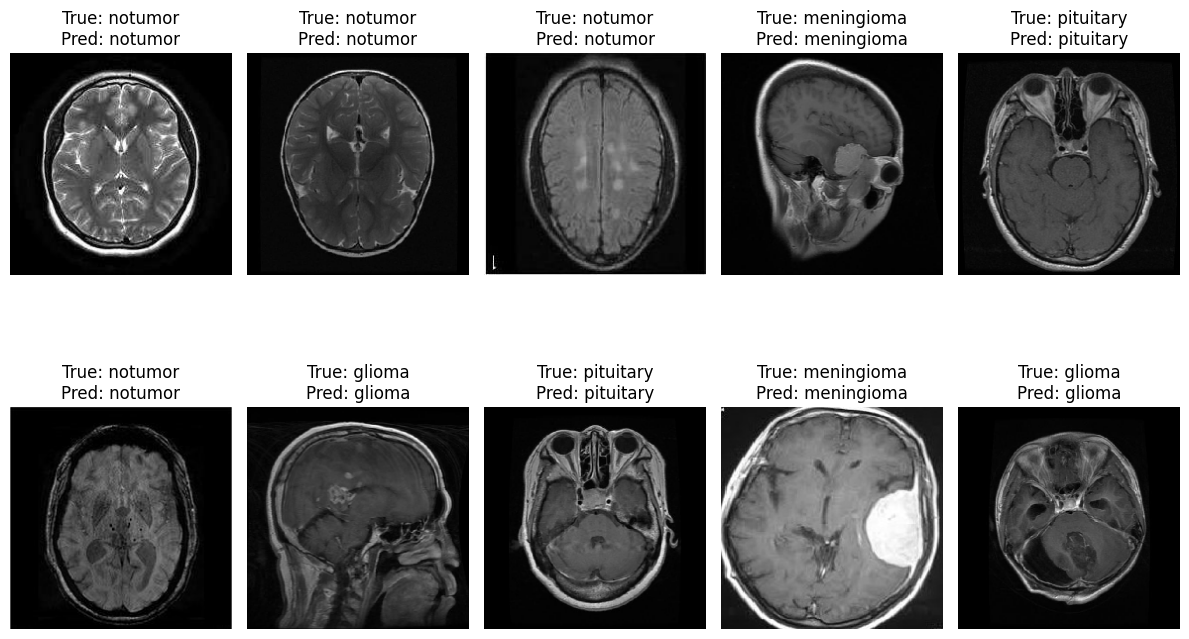

In [39]:
selected_indices =np.random.randint(0, len(img_paths), size=10)
selected_img_paths = [img_paths[i] for i in selected_indices]
selected_true_labels = [true_labels[i] for i in selected_indices]
selected_predicted_labels = [vgg19_predicted_labels[i] for i in selected_indices]

# Plot the images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_img_paths):
    plt.subplot(2, 5, i + 1)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    true_label = selected_true_labels[i]
    predicted_label = selected_predicted_labels[i]
    color = 'black' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

##### DenseNet121 Image Predictions

In [52]:
# Predict with the custom model
densenet_predictions = model2.predict(images)

# Decode predictions to class labels
densenet_predicted_labels = [class_labels[np.argmax(pred)] for pred in densenet_predictions]

 3/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step

W0000 00:00:1717675193.600870     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step


W0000 00:00:1717675205.826117     206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


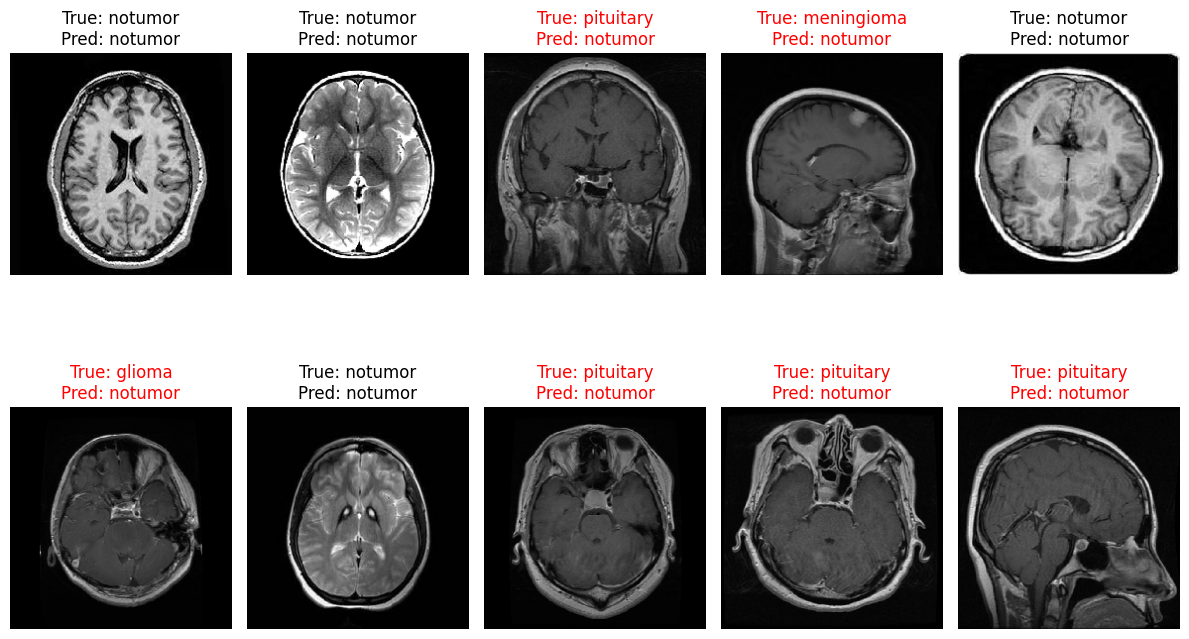

In [40]:
selected_indices =np.random.randint(0, len(img_paths), size=10)
selected_img_paths = [img_paths[i] for i in selected_indices]
selected_true_labels = [true_labels[i] for i in selected_indices]
selected_predicted_labels = [densenet_predicted_labels[i] for i in selected_indices]

# Plot the images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_img_paths):
    plt.subplot(2, 5, i + 1)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    true_label = selected_true_labels[i]
    predicted_label = selected_predicted_labels[i]
    color = 'black' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

##### VGG16 Image Predictions

In [53]:
# Predict with the custom model
vgg16_predictions = model3.predict(images)

# Decode predictions to class labels
vgg16_predicted_labels = [class_labels[np.argmax(pred)] for pred in vgg16_predictions]

 2/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step 

W0000 00:00:1717675214.447596     208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step


W0000 00:00:1717675219.925024     208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


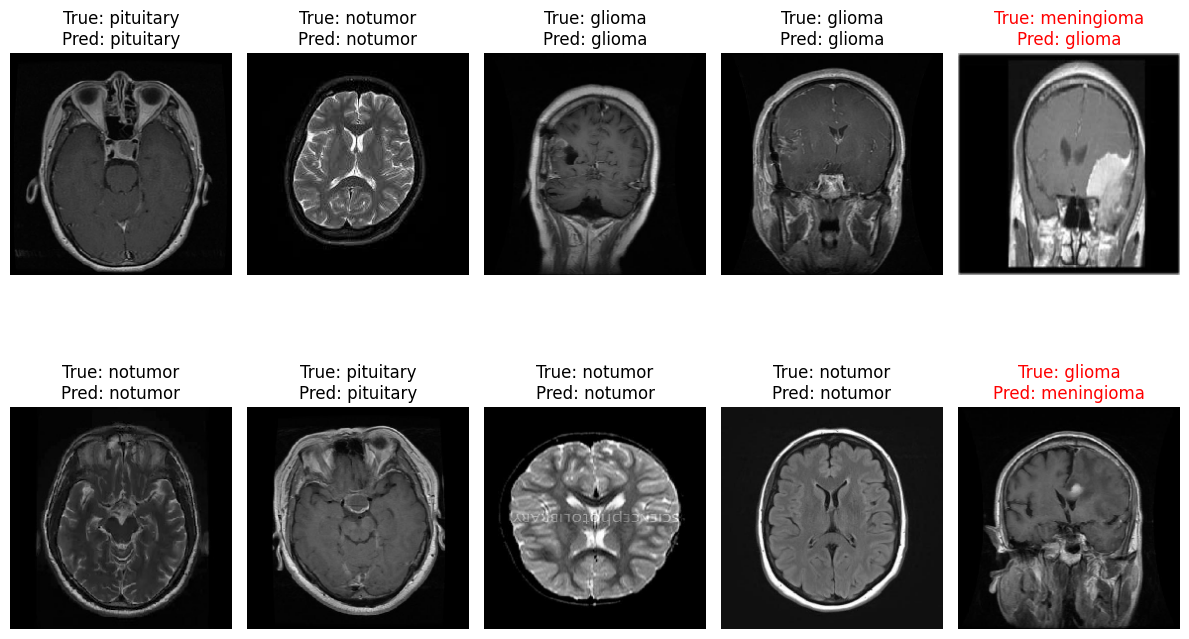

In [41]:
selected_indices =np.random.randint(0, len(img_paths), size=10)
selected_img_paths = [img_paths[i] for i in selected_indices]
selected_true_labels = [true_labels[i] for i in selected_indices]
selected_predicted_labels = [vgg16_predicted_labels[i] for i in selected_indices]

# Plot the images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(selected_img_paths):
    plt.subplot(2, 5, i + 1)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    true_label = selected_true_labels[i]
    predicted_label = selected_predicted_labels[i]
    color = 'black' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

##### Custom CNN Predictions

In [ ]:
# Predict with the custom model
CNN_predictions = cnn_model.predict(images)

# Decode predictions to class labels
CNN_predicted_labels = [class_labels[np.argmax(pred)] for pred in cnn_predictions]

### Model Comparison

In [35]:
compare= pd.DataFrame({'Actual':true_labels,'Custom CNN':CNN_predicted_labels,'VGG19 Predicted':vgg19_predicted_labels, 'DenseNet Predicted':densenet_predicted_labels, 'VGG16 Predicted':vgg16_predicted_labels})

In [36]:
compare.head(20)

Actual VGG19 Predicted DenseNet Predicted VGG16 Predicted
0   glioma          glioma            notumor          glioma
1   glioma      meningioma            notumor          glioma
2   glioma          glioma            notumor          glioma
3   glioma          glioma            notumor          glioma
4   glioma          glioma            notumor          glioma
5   glioma          glioma            notumor          glioma
6   glioma          glioma            notumor          glioma
7   glioma          glioma            notumor          glioma
8   glioma          glioma            notumor          glioma
9   glioma          glioma            notumor          glioma
10  glioma          glioma            notumor          glioma
11  glioma          glioma            notumor          glioma
12  glioma          glioma            notumor          glioma
13  glioma          glioma            notumor          glioma
14  glioma          glioma            notumor          glioma
15  glioma      meningioma            notumor      meningioma
16  glioma          glioma            notumor          glioma
17  glioma          glioma            notumor          glioma
18  glioma          glioma            notumor          glioma
19  glioma          glioma            notumor          glioma

### VGG19 Train Accuracy Vrs Validation Accuracy

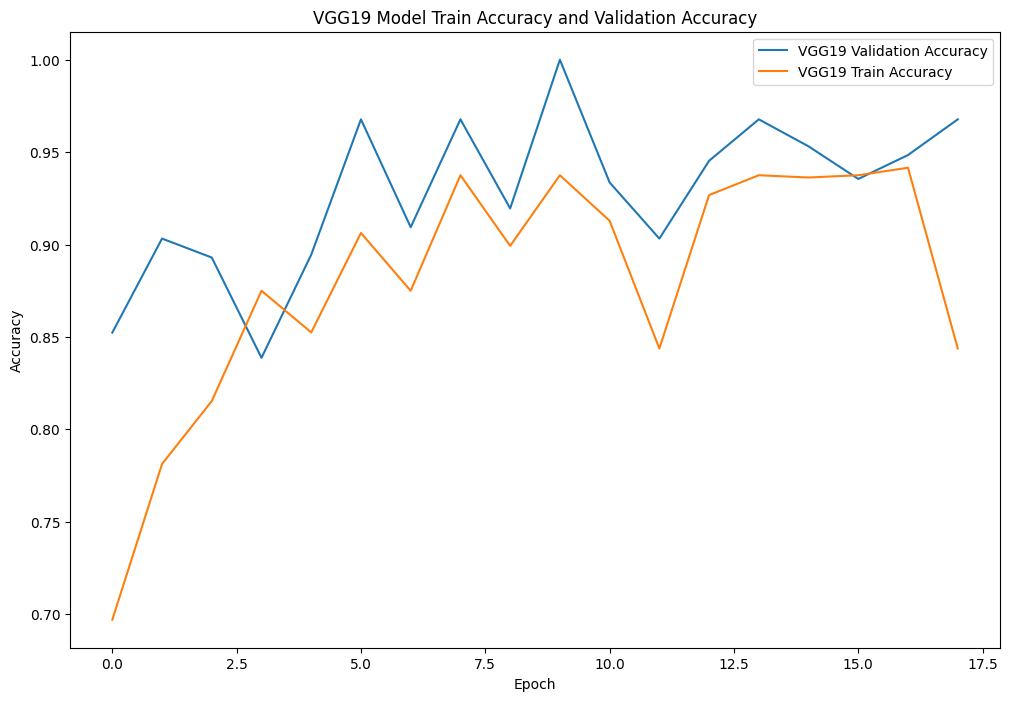

In [40]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(vgg19_history.history['val_accuracy'], label='VGG19 Validation Accuracy')
plt.plot(vgg19_history.history['accuracy'], label='VGG19 Train Accuracy')
plt.title('VGG19 Model Train Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG19 Train Loss Vrs Validation Loss

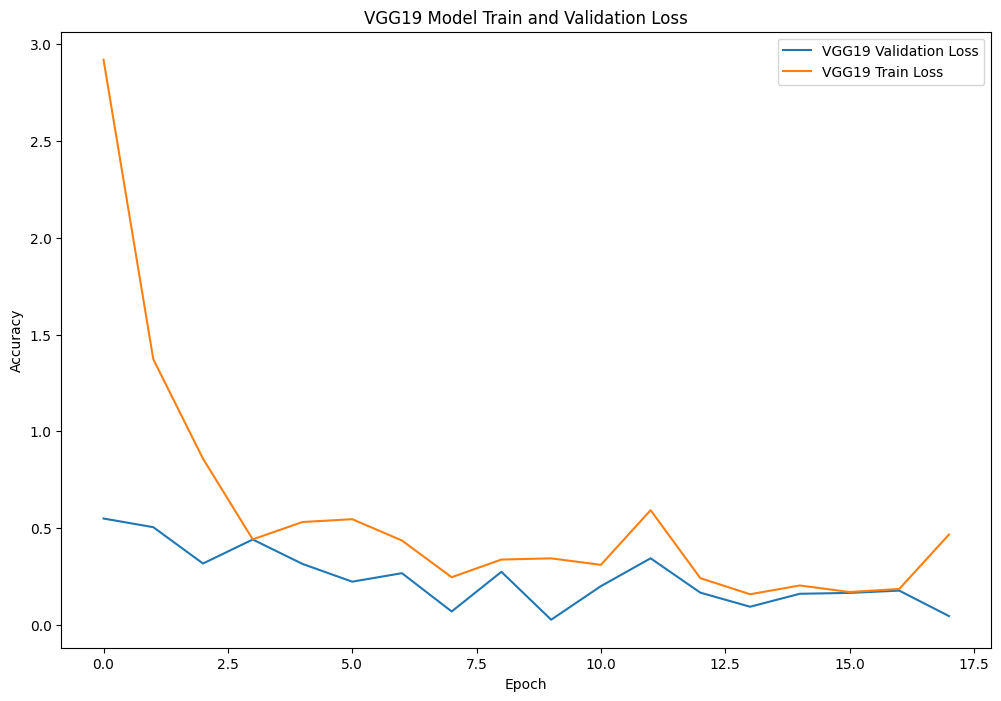

In [41]:
plt.figure(figsize=(12, 8))
plt.plot(vgg19_history.history['val_loss'], label='VGG19 Validation Loss')
plt.plot(vgg19_history.history['loss'], label='VGG19 Train Loss')
plt.title('VGG19 Model Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### DenseNet121 Train Accuracy Vrs Validation Accuracy

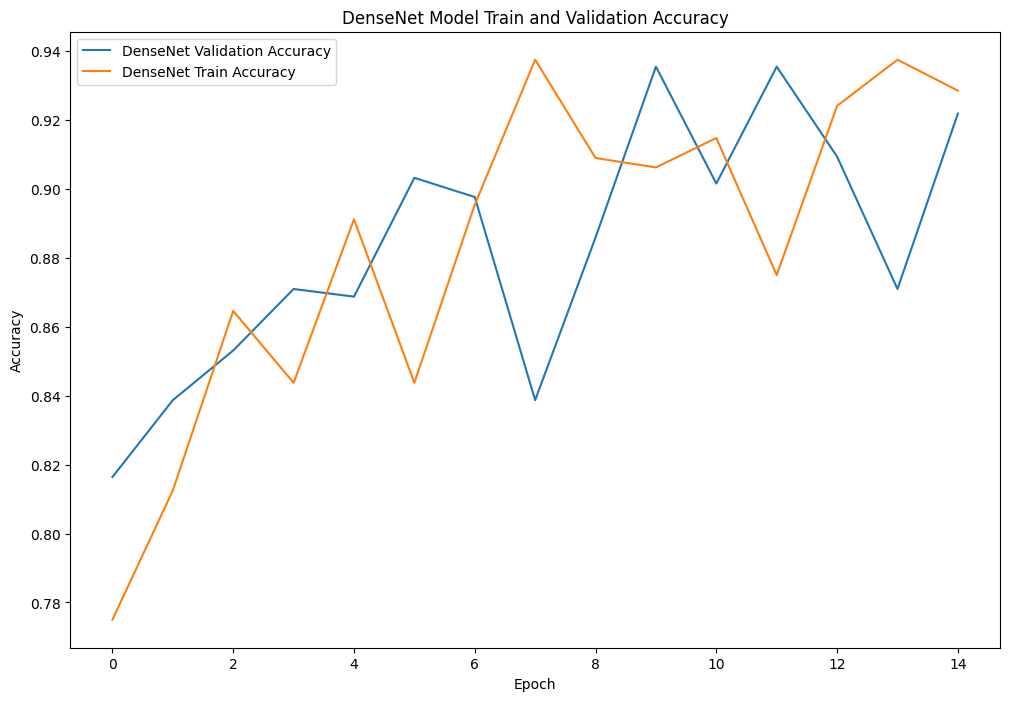

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(densenet_history.history['val_accuracy'], label='DenseNet Validation Accuracy')
plt.plot(densenet_history.history['accuracy'], label='DenseNet Train Accuracy')
plt.title('DenseNet Model Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### DenseNet121 Train Loss Vrs Validation Loss

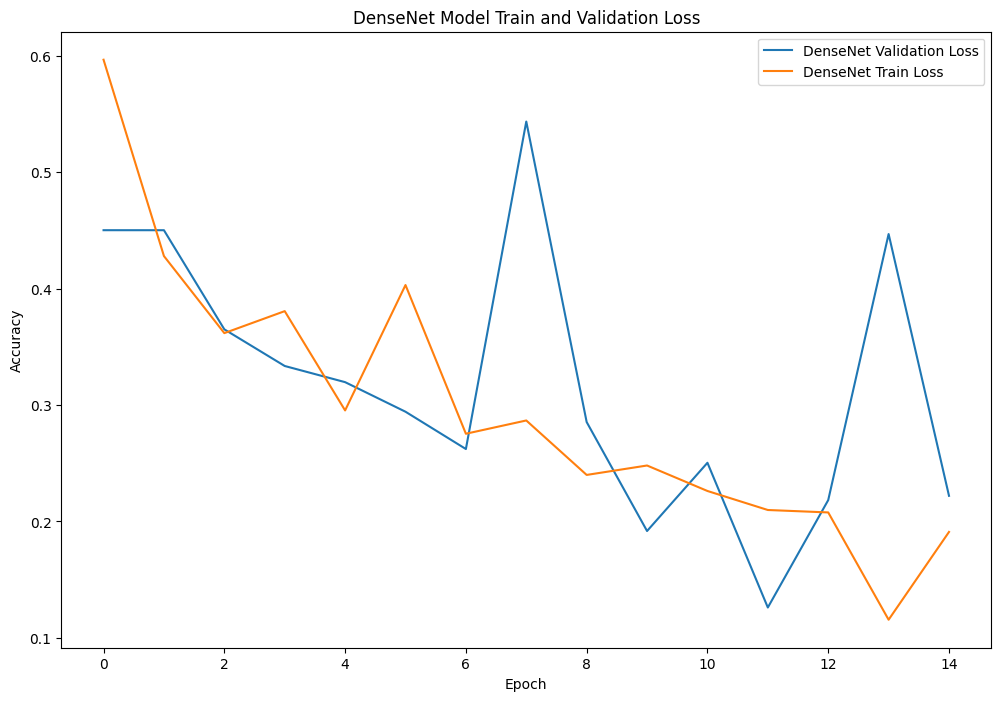

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(densenet_history.history['val_loss'], label='DenseNet Validation Loss')
plt.plot(densenet_history.history['loss'], label='DenseNet Train Loss')
plt.title('DenseNet Model Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG16 Train Accuracy Vrs Validation Accuracy

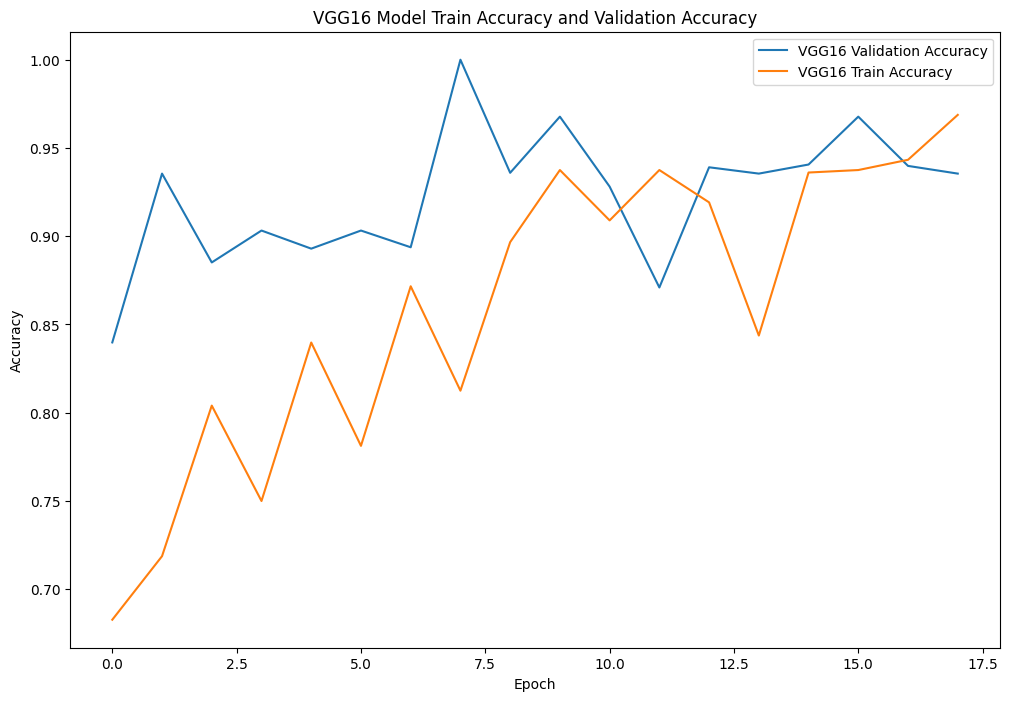

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Train Accuracy')
plt.title('VGG16 Model Train Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG16 Train Loss Vrs Validation Loss

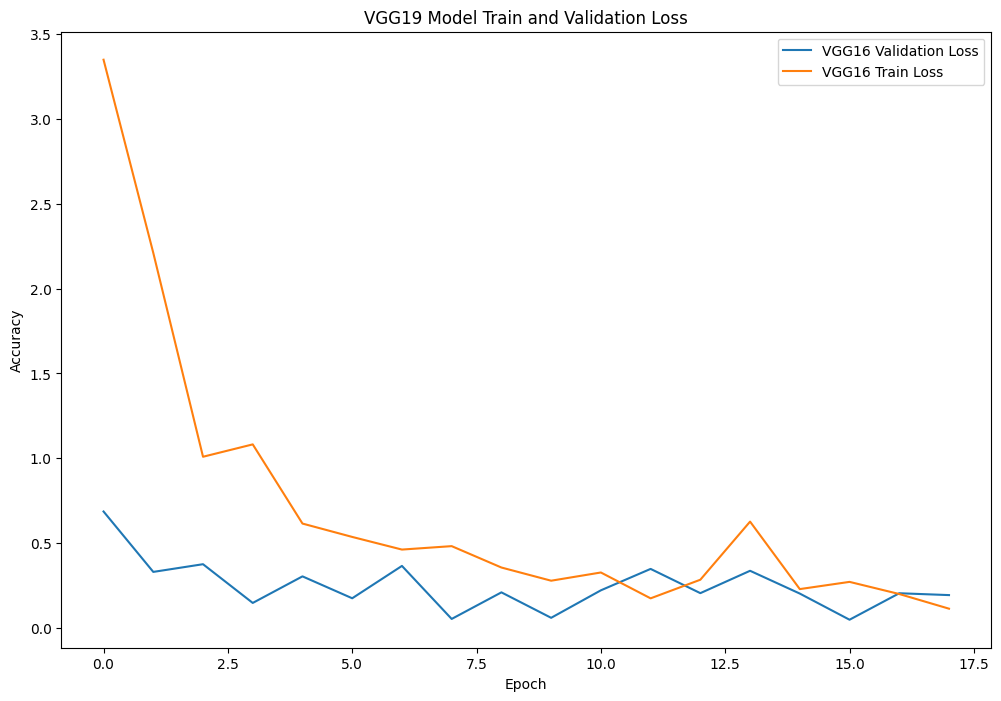

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(vgg16_history.history['val_loss'], label='VGG16 Validation Loss')
plt.plot(vgg16_history.history['loss'], label='VGG16 Train Loss')
plt.title('VGG19 Model Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

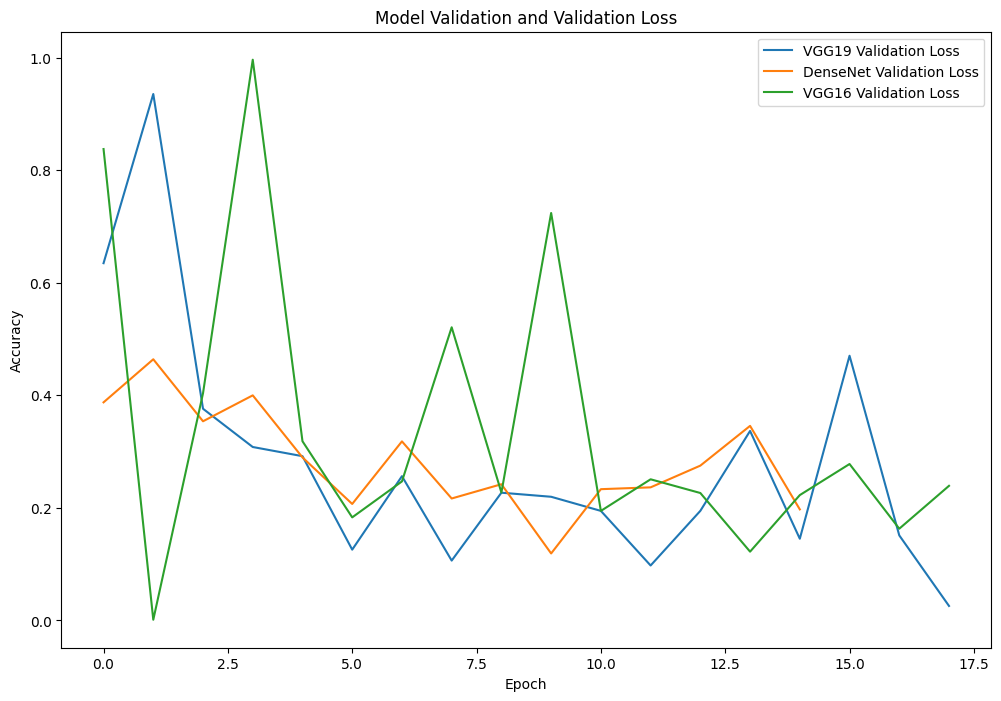

In [45]:
# plt.figure(figsize=(12, 8))
# plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
# plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
# plt.title('CNN Model Train Accuracy and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

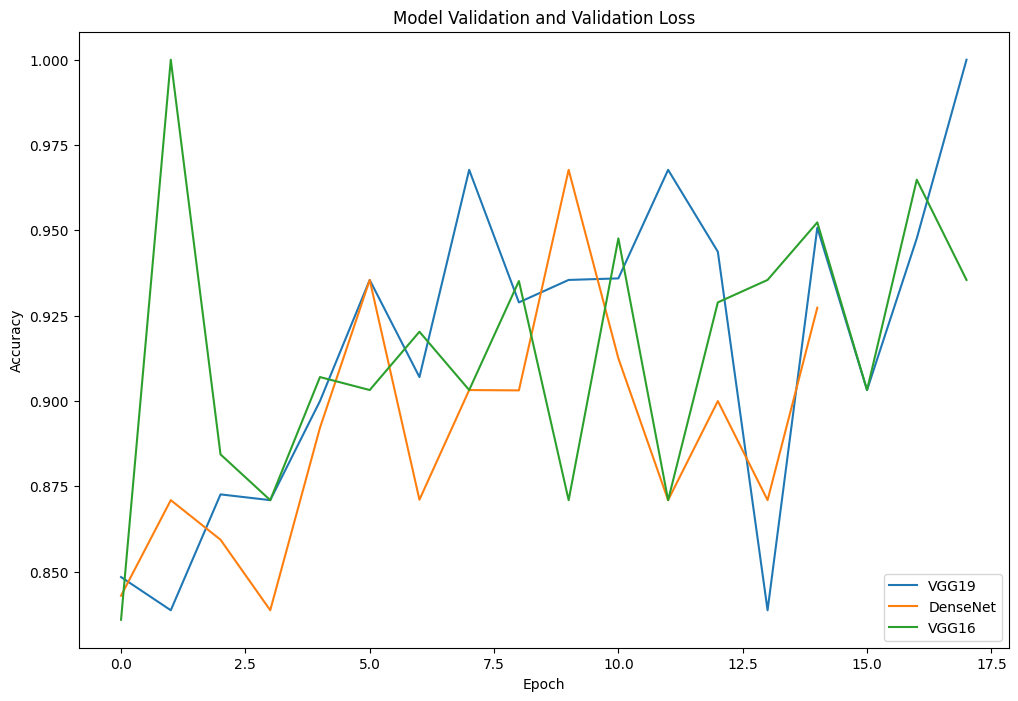

In [47]:
# plt.figure(figsize=(12, 8))
# plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
# plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
# plt.title('CNN Model Train and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 8))
# plt.plot(vgg19_history.history['val_loss'], vgg19_history.history['val_accuracy'], label='VGG19')
# plt.plot(densenet_history.history['val_loss'],densenet_history.history['val_accuracy'], label='DenseNet')
# plt.plot(vgg16_history.history['val_loss'],vgg16_history.history['val_accuracy'],label='VGG16')
# plt.title('Model Validation and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

### F1 Scores 

In [54]:
vgg19_true_label_indices = [class_labels.index(label) for label in true_labels]
vgg19_predicted_label_indices = [class_labels.index(label) for label in vgg19_predicted_labels]

# Compute the F1 score
vgg19_f1 = f1_score(vgg19_true_label_indices, vgg19_predicted_label_indices, average='weighted')
print(f"Weighted F1 Score: {vgg19_f1:.2f}")

Weighted F1 Score: 0.95


In [55]:
densenet_true_label_indices = [class_labels.index(label) for label in true_labels]
densenet_predicted_label_indices = [class_labels.index(label) for label in densenet_predicted_labels]

# Compute the F1 score
densenet_f1 = f1_score(densenet_true_label_indices, densenet_predicted_label_indices, average='weighted')
print(f"Weighted F1 Score: {densenet_f1:.2f}")

Weighted F1 Score: 0.15


In [56]:
vgg16_true_label_indices = [class_labels.index(label) for label in true_labels]
vgg16_predicted_label_indices = [class_labels.index(label) for label in vgg16_predicted_labels]

# Compute the F1 score
vgg16_f1 = f1_score(vgg16_true_label_indices, vgg16_predicted_label_indices, average='weighted')
print(f"Weighted F1 Score: {vgg16_f1:.2f}")

Weighted F1 Score: 0.94


##### Model Metrics Comparison for VGG19, VGG16 & DenseNet121

In [57]:
metrics=pd.DataFrame({'Model':['VGG19','DenseNet','VGG16'], 'f1_score':[vgg19_f1,densenet_f1,vgg16_f1], 'Train Accuracy':[vgg19_train_acc,densenet_train_acc,vgg16_train_acc], 'Validation Accuracy':[vgg19_val_acc,densenet_val_acc,vgg16_val_acc], 'Train Loss':[vgg19_train_loss, densenet_train_loss, vgg16_train_loss], 'Validation Loss':[vgg19_val_loss, densenet_val_loss, vgg16_val_loss]})

In [64]:
metrics

Model  f1_score  Train Accuracy  Validation Accuracy  Train Loss  \
0     VGG19  0.946373        0.990371             0.946606    0.032788   
1  DenseNet  0.145821        0.949230             0.920671    0.133476   
2     VGG16  0.939550        0.987920             0.940503    0.036807   

   Validation Loss  
0         0.181890  
1         0.221218  
2         0.200573

### Metrics for Custom CNN

In [63]:
new=pd.DataFrame({'Model':['Custom CNN'],'f1_score':[0.91198150],'Train Accuracy':[0.964635],'Validation Accuracy':[0.9138062], 'Train Loss':[0.48959422],'Validation Loss':[0.879142582]})

In [65]:
new

Model  f1_score  Train Accuracy  Validation Accuracy  Train Loss  \
0  Custom CNN  0.911982        0.964635             0.913806    0.489594   

   Validation Loss  
0         0.879143

### Model(All 4) Vrs F1-Score

In [69]:
metrics=pd.concat([metrics,new], ignore_index=True)

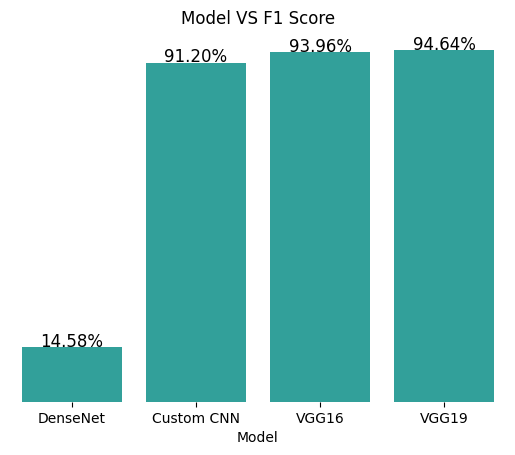

In [81]:
sns.barplot(x='Model', y='f1_score', data=metrics, order=['DenseNet','Custom CNN','VGG16', 'VGG19'], color='lightseagreen')
sns.despine(left=True, bottom=True, right=True, top=True)
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.001, f'{height:.2%}',
             ha="center", fontdict={'fontsize':12})
plt.xlabel('Model')
plt.ylabel('')
plt.yticks([])
plt.title('Model VS F1 Score')
plt.show()

### Model(All 4) Vrs Validation Loss


In [85]:
metrics.sort_values(by=['Validation Loss', 'f1_score'])

Model  f1_score  Train Accuracy  Validation Accuracy  Train Loss  \
0       VGG19  0.946373        0.990371             0.946606    0.032788   
2       VGG16  0.939550        0.987920             0.940503    0.036807   
1    DenseNet  0.145821        0.949230             0.920671    0.133476   
3  Custom CNN  0.911982        0.964635             0.913806    0.489594   

   Validation Loss  
0         0.181890  
2         0.200573  
1         0.221218  
3         0.879143

In [73]:
metrics=metrics.drop(4, axis=0)

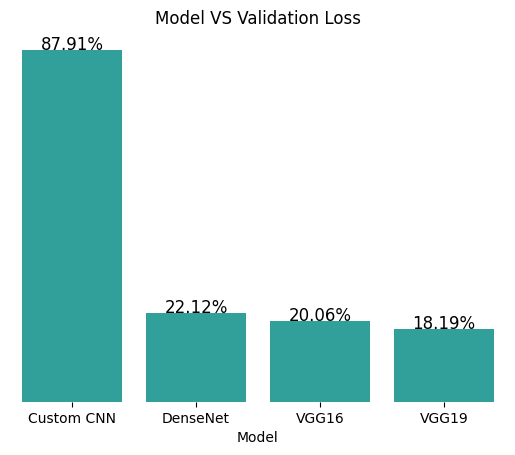

In [84]:
sns.barplot(x='Model', y='Validation Loss', data=metrics, order=['Custom CNN','DenseNet','VGG16', 'VGG19'], color='lightseagreen')
sns.despine(left=True, bottom=True, right=True, top=True)
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.001, f'{height:.2%}',
             ha="center", fontdict={'fontsize':12})
plt.xlabel('Model')
plt.ylabel('')
plt.yticks([])
plt.title('Model VS Validation Loss')
plt.show()